In [41]:
%matplotlib inline

In [42]:
import numpy as np
from functools import reduce
from operator import mul
from scipy.linalg import solve
import matplotlib.pyplot as plt

In [30]:
def sanitize(line):
    # remove semi-colons, parenthesis and commas
    mt = str.maketrans(
        {';': None, '(': None, ')': None, ',': None, ':': None}
    )
    return line.translate(mt)

prod = lambda a: reduce(mul, a, 1)
    
def _process_grid(fd, is_matrix):
    for line in fd:
        if line.startswith('0:'):
            line = sanitize(line[2:]).strip().split()
            ndims = (len(line)-1)//2
            lo=[int(x) for x in line[:ndims]]
            hi=[int(x) for x in line[ndims+1:]]
            grid_size = [h-l+1 for h, l in zip(hi, lo)]
            if is_matrix:
                shape = (prod(grid_size), prod(grid_size))
            else:
                shape = (prod(grid_size), )
            return grid_size, np.zeros(shape)
    raise TypeError("Grid size not found. Improperly formatted file")


def process_grid(file_descriptor, is_matrix):
    """ read an opened file to determine matrix size """
    for line in file_descriptor:
        if line.startswith('Grid:'):
            return _process_grid(file_descriptor, is_matrix)
    raise TypeError("'Grid:' not found in file")   
    
    
def _process_stencil(fd):
    stencil = []
    for line in fd:
        # stencil ends with a blank line
        if len(line.strip()) == 0:
            return stencil
        # properly formatted stencil is d: i j
        line = sanitize(line).strip().split()
        if len(line) >= 3:
            idx = int(line[0])
            if idx != len(stencil):
                raise TypeError("Expected Stencils in different order")
            stencil.append([int(x) for x in line[1:]])
            
    
def process_stencil(file_descriptor, is_matrix):
    """ read an opened file and return stencil """
    if not is_matrix:
        return None
    for line in file_descriptor:
        if line.startswith('Stencil:'):
            return _process_stencil(file_descriptor,)
    raise TypeError("'Stencil:' not found in file")
    

def _inbounds(grid):
    def _(ijk):
        for idx, upper in zip(ijk, grid):
            if idx < 0 or idx >= upper:
                return False
        return True
    return _
    
def _1d_coordinate(grid):
    def _(ijk):
        c = ijk[0]
        for i, n in zip(ijk[1:], grid):
            c += i*n
        return c
    return _
    
def _fill_matrix(fd, grid, mat, st):
    if st is None and mat.ndim != 1:
        raise TypeError("expect a vector")
    
    inbounds = _inbounds(grid)
    coord = _1d_coordinate(grid)
    ndim = len(grid)
    
    for line in fd:
        line = sanitize(line[2:]).strip().split()
        ijk = tuple(int(x) for x in line[:ndim])
        if not inbounds(ijk):
            continue
        
        row = coord(ijk)
       
        if st is None:
            # filling a vector
            mat[row] = float(line[ndim+1])
        else:
            st_idx = int(line[ndim])           
            ijk_off = tuple(base+off for base, off in zip(ijk, st[st_idx]))
       
            if not inbounds(ijk_off):
                continue
            col = coord(ijk_off)
            mat[row, col] = float(line[ndim+1])
    
    
def fill_matrix(file_descriptor, grid, matrix, stencil):
    """ Fill matrix with data at specified offsets """
    for line in file_descriptor:
        if line.startswith("Data:"):
            return _fill_matrix(file_descriptor, grid, matrix, stencil)
    raise TypeError("'Data:' not found in file")
        
    
    
def parse_struct_hypre(file_name):
    with open(file_name, 'r') as f:
        ismatrix = 'matrix' in f.readline().lower()
        # find size and start of data
        grid, mat = process_grid(f, ismatrix)
        st = process_stencil(f, ismatrix)
        fill_matrix(f, grid, mat, st)
        return mat

In [32]:
mat = parse_struct_hypre('HYPRE_StructMatrix.out.00000')

In [33]:
mat

array([[ 2.5 , -0.25,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-0.25,  2.25, -0.25, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.25,  2.25, ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  2.25, -0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., -0.25,  2.25, -0.25],
       [ 0.  ,  0.  ,  0.  , ...,  0.  , -0.25,  2.5 ]])

In [35]:
rhs = parse_struct_hypre('HYPRE_RHS.out.00000')

In [37]:
rhs

array([  1.03491932e-07,   3.17461125e-03,   2.69020292e-03,
         2.21756235e-03,   1.77501701e-03,   1.38100549e-03,
         1.02231855e-03,   6.34136533e-04,   1.45855303e-04,
        -4.42524675e-04,  -1.06039833e-03,  -1.64294508e-03,
        -2.17695476e-03,  -2.68086500e-03,  -3.17300237e-03,
         1.03491932e-07,  -3.17300237e-03,   6.11838383e-06,
         3.47573661e-05,   1.48254588e-04,   4.74398879e-04,
         1.13721863e-03,   2.03913315e-03,   2.73149264e-03,
         2.73149264e-03,   2.03913315e-03,   1.13721863e-03,
         4.74398879e-04,   1.48254588e-04,   3.47573661e-05,
         6.11838383e-06,   3.17461125e-03,  -2.68086500e-03,
         3.47573661e-05,   1.93132694e-04,   8.06855939e-04,
         2.53541435e-03,   5.99055379e-03,   1.06344873e-02,
         1.41725942e-02,   1.41725942e-02,   1.06344873e-02,
         5.99055379e-03,   2.53541435e-03,   8.06855939e-04,
         1.93132694e-04,   3.47573661e-05,   2.69020292e-03,
        -2.17695476e-03,

In [39]:
sol = solve(mat, rhs)

In [43]:
sol.min(), sol.max()

(-0.0015719174827512534, 0.72335651481273644)

(256,)

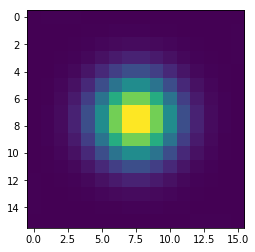

In [48]:
plt.imshow(sol.reshape(16, 16))